# **Task P8**
## Analyzing Twitter Data using NLP

##### This task focuses on analyzing user replies to Covid-19 news published on the social media platform X (formerly known as Twitter) using some basic natural language processing (NLP) techniques. 

##### The task uses the `replies.csv` dataset, which contains the information about user replies to the Covid-19 news posted on Twitter. The columns capture the content related to the individual replies such as `text` (the actual text content of the reply), `id` (a unique ID for the reply itself), `conversation_id` (linking the reply to a specific conversation thread), `in_reply_to_user_id` (identifying the target user of the reply), and `possibly_sensitive` (indicating if the content may be sensitive). Additional informaiton include `author_id` (the unique ID of the reply's author), `author_followers` (the count of the author's followers),`author_tweets` (total tweets made by the author), and `author_location` (the geographical location of the author). Moreover, engagement metrics are tracked through columns like `retweets`, `replies`, `likes`, and `quote_count`. Time and location metadata are captured by `created_at` and `geo`, respectively, with `account` specifying the account name of the news publishers (e.g., BBC).

<img src="pic.png" alt="SIT112 News Tweets!" width="1800" height="200">

### A. Instructions

1. `To complete this task, you must first study the solution notebook; then try to do it yourself. You can copy the solutions into ChatGPT and ask for clarification or more examples.`
2. Complete and submit the TaskCompletionReport form in PDF format using Ontrack. You can do this by the end of Week 12, but feedback will only be provided for submissions received by 11 AM of the due date.
3. Do **not** include the solution (yours or the one provided to you) in your submission.
4. The workshops are the primary venue for you to seek help if you need any clarification/assitance. The tutors are there to help you complete and submit the tasks. Please avoid emailing your code or screenshots to the tutors outside workshop hours. 
5. Consider using online resources such as ChatGPT to strenghten your undertanding of the task. 

Good luck :)

In [2]:
import importlib
import subprocess

# The following lines should install all libraries you need - you can install the libraries manually if the script did not work 
required_modules = ['pandas', 'seaborn', 'matplotlib', 'numpy', 'datetime', 'sklearn', 'nltk', 'textblob', 'textblob', 'collections', 'numpy', 'warnings']
for module in required_modules:
    try:
        importlib.import_module(module)
    except ImportError:
        print(f"{module} module not found. Installing...")
        subprocess.check_call(['pip', 'install', module])

print("All required modules are installed.")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import datetime as dt
from collections import Counter
import re
import warnings
import nltk
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
# Set the maximum number of columns and rows displayed
pd.set_option('display.max_columns', None)  # None means no limit
pd.set_option('display.max_rows', None)  # None means no limit
# You can also adjust the width of each column and the maximum column width
pd.set_option('display.max_colwidth', None)  # None means no truncation on column width

All required modules are installed.


### B. Write Python code that performs (answers) the following operations (questions) 

##### 1. Read the data from the .csv file into a DataFrame and display the first five rows.

In [3]:
# write your code here

df = pd.read_csv('replies.csv')
df.head()

,author_id,author_followers,author_tweets,author_location,id,conversation_id,source,in_reply_to_user_id,possibly_sensitive,text,created_at,geo,retweets,replies,likes,quote_count,account
0,2,1,3827,NaN,1.480000e+18,1.480000e+18,NaN,2.604917e+07,False,@RobinLaRoca @guardian I don't want a payment.\nI want the unvaxxed to pay every last red cent for public hospital treatment rendered to them,2022-01-01T03:31:03Z,NaN,0,2,0,0,guardian
1,3,939,49244,Sheffield,1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,@guardian I'm fine with that as long as they backdate the payments for everyone.,2022-01-01T00:42:39Z,{'place_id': '07e9c7d1954fff64'},0,1,0,0,guardian
2,4,318,4519,"Santiago, Chile",1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,"@guardian Yes, for big pharma",2022-01-01T00:37:59Z,NaN,1,0,1,0,guardian
3,5,2812,320641,Earth,1.480000e+18,1.480000e+18,NaN,1.367531e+06,False,@FoxNews a vaccine most Missourians won’t take,2022-01-01T07:39:51Z,NaN,0,0,5,0,FoxNews
4,6,350,1581,"Conway, AR",1.480000e+18,1.480000e+18,NaN,1.190000e+18,False,"@nikki6ixx1 @FoxNews I currently have Covid, im non vaccinated and feeling perfectly fine. Please explain to me how am I going to die because of this virus??",2022-01-01T13:30:39Z,NaN,0,2,0,0,FoxNews


##### 2. Clean the reply texts as listed below. You can use ChatGPT to generate regular expressions for these cleaning operations. 

- Remove @ Mentions: Strip out any @ mentions in the reply texts, which typically refer to other users and are not relevant for general analysis.
- Remove Hashtags: Eliminate the '#' symbol but keep the subsequent text, which might be relevant for understanding the topic of the reply.
- Remove Retweet Indicators: Remove any 'RT' symbols used to indicate retweets, as they do not contribute to text content.
- Remove URLs: Strip out any web links (URLs), which are common in reply texts but irrelevant to text analysis.
- Remove Punctuation: Eliminate all punctuation marks to reduce variability in the reply texts.
- Convert to Lowercase: Standardize all reply texts to lowercase to ensure uniformity in the analysis.

In [4]:
# Write your code here

# This function cleans the text by removing unwanted characters and formatting
def clean_text(text):
    try:
        # Remove @ mentions (usernames)
        text = re.sub(r'@[A-Za-z0-9]+', '', text)
        # Remove hashtag symbols but keep the text after the hash for context
        text = re.sub(r'#', '', text)
        # Remove 'RT' text indicating a retweet
        text = re.sub(r'RT[\s]+', '', text)
        # Remove hyperlinks
        text = re.sub(
            r'https?://[^\s<>"]+|www\.[^\s<>"]+', 
            "", text)
        # Remove all types of punctuation and special characters
        text = re.sub(r'[^\w\s]', '', text)
        # Convert all characters in the text to lowercase to standardize for further analysis
        text = text.lower()
    except Exception as e:
        # Print the error if any occurs during text cleaning
        print(e)
    return text

# Clean the text in the DataFrame
df['text'] = df['text'].apply(clean_text)

##### 3. Remove from the reply texts the stopwords and the custom list of words that are unwanted:

- Utilize a list of predefined stopwords from NLTK tailored for the English language (from nltk.corpus import stopwords).
- Define a custom list of words to be excluded that are specifically irrelevant or overused in the reply texts.
- Remove stopwords and custom words: filter out these words from the (reply) text to focus on more meaningful words for analysis.

In [4]:
# Write your code here

# This function removes common stopwords and a predefined list of unwanted words (can be modified) from the text
def remove_words(text):
    # Define a list of words specific to the context that we want to exclude from analysis
    excluded_words = ['covid', 'covid19', 'covid-19', 'u', 'say', 'said', 'amid', 'weel', 'oh', 'new', 'BCWorld', 
                      'will', 'still', 'someone', 'many', 'now', 'going', 'everyone', 'use', 'let', 'become', 'thing', 
                      'around', 'way', 'know', 'NUM', 'dont']
    # Get the list of all English stopwords
    stop_words = stopwords.words('english')
    # Combine both lists and ensure all words are considered in lowercase
    combined_words = set(stop_words + excluded_words)
    # Reconstruct the text by excluding stopwords and additional excluded words
    text_new = ' '.join(word for word in text.split() if word.lower() not in combined_words)
    return text_new

# Remove unwanted words from the text
df['text'] = df['text'].apply(remove_words)

##### 4. What are the 5 most frequent words in the replies per account (news publisher, e.g., BBC)?

In [5]:
# Write your code here

# Define a function to extract words from text using regular expressions
def extract_words(text):
    return re.findall(r'\b\w+\b', text.lower())  # Find all word-like substrings in lowercase text

# Apply the extract_words function to each text entry in the 'text' column of the dataframe 'df'
df['words'] = df['text'].apply(extract_words)

# Group the dataframe by the 'account' column and sum the lists in the 'words' column
grouped_data = df.groupby('account')['words'].sum()

# Define a function to determine the top 5 most common words in a list of words
def get_top_words(words):
    word_counts = Counter(words)
    return word_counts.most_common(5)

# Apply the get_top_words function to each group of words aggregated by publisher
top_words_per_publisher = grouped_data.apply(get_top_words)

# Display the top words per publisher results
display(top_words_per_publisher)

account
9NewsAUS                   [(vaccine, 38), (get, 38), (like, 34), (people, 28), (would, 23)]
BBCWorld              [(people, 105), (vaccine, 99), (get, 93), (vaccinated, 85), (one, 61)]
CBC                                    [(go, 3), (lies, 3), (every, 2), (day, 2), (news, 2)]
CNN              [(people, 381), (get, 305), (vaccine, 300), (vaccinated, 212), (like, 173)]
FoxNews          [(people, 567), (get, 478), (vaccine, 462), (like, 315), (vaccinated, 286)]
MSNBC                    [(people, 87), (_vladeck, 45), (vaccine, 35), (get, 32), (amp, 31)]
SkyNews         [(people, 129), (vaccine, 100), (vaccinated, 78), (get, 77), (vaccines, 53)]
guardian                    [(people, 54), (vaccine, 36), (like, 25), (need, 24), (get, 22)]
timesofindia    [(vaccine, 25), (people, 15), (modi, 14), (ao2022, 12), (novakdjokovic, 12)]
Name: words, dtype: object

##### 5. Classify the sentiment of each reply as positive, negative, or neutral based on the `text` column. Then visualize the ratio of the replies with positive, negative, or neutral sentiments per news publisher (account). 


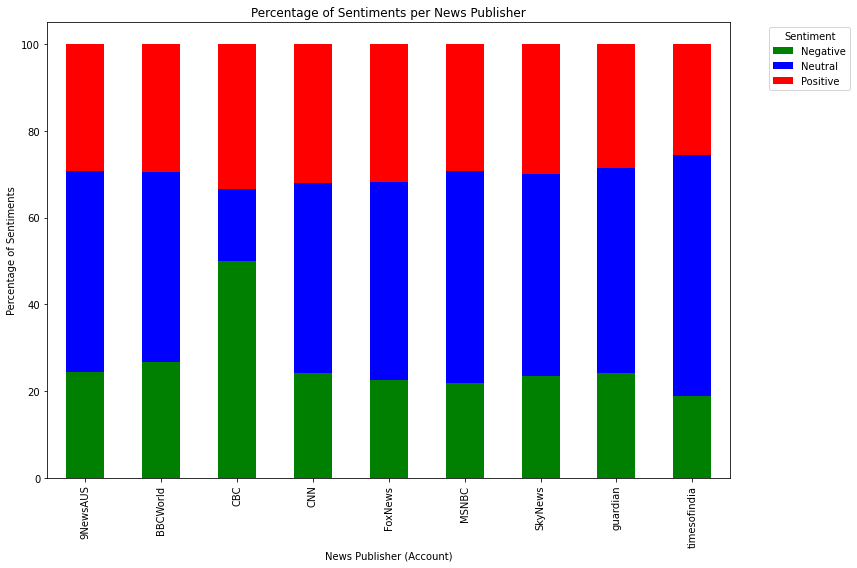

In [ ]:
# Write your code here

# Define a function to detect the sentiment of a given text
def detect_sentiment(text):
    # Create a TextBlob object which provides access to common text-processing operations
    testimonial = TextBlob(text)
    # Check if the polarity of the text is positive
    if testimonial.sentiment.polarity > 0:
        return 'Positive'
    # Check if the polarity of the text is neutral
    elif testimonial.sentiment.polarity == 0:
        return 'Neutral'
    # If the polarity is neither positive nor neutral, it must be negative
    else:
        return 'Negative'

# Apply the 'detect_sentiment' function to each row in the 'text' column of the DataFrame
# This adds a new column to the DataFrame with the detected sentiment for each text entry
df['sentiment'] = df['text'].apply(detect_sentiment)

# Group the data by the 'account' column and then count the occurrences of each sentiment
# This aggregates the sentiment data per account, normalizing the counts to get proportions
account_sentiments = df.groupby('account')['sentiment'].value_counts(normalize=True).unstack(fill_value=0)

# Multiply by 100 to convert proportions to percentages
# This adjustment makes the data more interpretable in the bar plot
account_sentiments = account_sentiments * 100

# Plotting
# Create a stacked bar plot to show the proportion of each sentiment by account
account_sentiments.plot(kind='bar', stacked=True, color=['green', 'blue', 'red'], ax=ax)
plt.title('Percentage of Sentiments per News Publisher')
plt.xlabel('News Publisher (Account)')
plt.ylabel('Percentage of Sentiments')
# Place the legend outside the plot area for better clarity
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()fig, ax = plt.subplots(figsize=(12, 8))


### C. Learn more
* https://www.sciencedirect.com/science/article/pii/S2468696423000125
* https://youtu.be/toM78JGJ_4s?si=8ESJ-yOV_H1iX74r
* https://youtu.be/QpzMWQvxXWk?si=CPvNgnZo3jsW4HL5
* https://youtu.be/o7OqhzMcDfs?si=9iFeYZq4TlVCMMRb